# EDA

In [6]:
import pandas as pd
from pathlib import Path


# Set up root directory path
root_dir = Path.cwd().parent
data_path = root_dir / 'data' / 'data.csv'

# load
df = pd.read_csv(data_path)

# 1.1 Peek at the top rows
print(df.head())

# 1.2 Basic shape / info
print(df.shape)
print(df.dtypes)

# 1.3 Check for missing values
print(df.isnull().sum())

print(df.columns)

# 1.4 Distribution of labels
print(df['Sentiment'].value_counts(normalize=True))


                                            Sentence Sentiment
0  The GeoSolutions technology will leverage Bene...  positive
1  $ESI on lows, down $1.50 to $2.50 BK a real po...  negative
2  For the last quarter of 2010 , Componenta 's n...  positive
3  According to the Finnish-Russian Chamber of Co...   neutral
4  The Swedish buyout firm has sold its remaining...   neutral
(5842, 2)
Sentence     object
Sentiment    object
dtype: object
Sentence     0
Sentiment    0
dtype: int64
Index(['Sentence', 'Sentiment'], dtype='object')
Sentiment
neutral     0.535775
positive    0.317015
negative    0.147210
Name: proportion, dtype: float64


count    5842.000000
mean       21.004793
std        10.306465
min         2.000000
25%        13.000000
50%        19.000000
75%        27.000000
max        81.000000
Name: token_count, dtype: float64


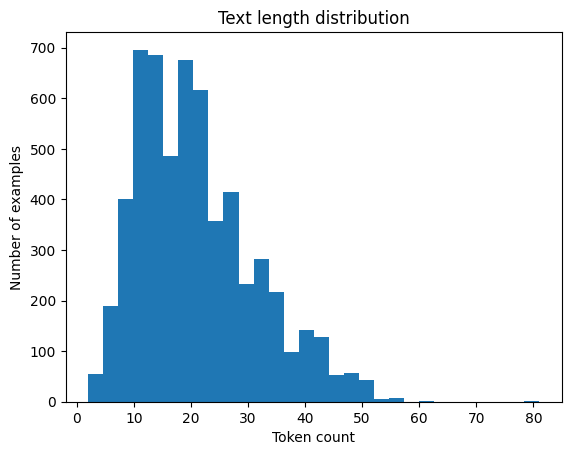

In [7]:
import matplotlib.pyplot as plt

# compute token counts (roughly) by splitting on whitespace
df['token_count'] = df['Sentence'].str.split().apply(len)

# summary stats
print(df['token_count'].describe())

# simple histogram with matplotlib
import matplotlib.pyplot as plt

plt.figure()
plt.hist(df['token_count'], bins=30)
plt.xlabel("Token count")
plt.ylabel("Number of examples")
plt.title("Text length distribution")
plt.show()


In [21]:
import transformers, inspect
from transformers import TrainingArguments

print(transformers.__version__)           # should be 4.51.3
print(transformers.__file__)              # path to the loaded module
print(TrainingArguments.__module__)       # should start with "transformers.training_args"
print(inspect.signature(TrainingArguments.__init__))  



4.51.3
/opt/conda/envs/finsen-env/lib/python3.10/site-packages/transformers/__init__.py
transformers.training_args
(self, output_dir: Optional[str] = None, overwrite_output_dir: bool = False, do_train: bool = False, do_eval: bool = False, do_predict: bool = False, eval_strategy: Union[transformers.trainer_utils.IntervalStrategy, str] = 'no', prediction_loss_only: bool = False, per_device_train_batch_size: int = 8, per_device_eval_batch_size: int = 8, per_gpu_train_batch_size: Optional[int] = None, per_gpu_eval_batch_size: Optional[int] = None, gradient_accumulation_steps: int = 1, eval_accumulation_steps: Optional[int] = None, eval_delay: Optional[float] = 0, torch_empty_cache_steps: Optional[int] = None, learning_rate: float = 5e-05, weight_decay: float = 0.0, adam_beta1: float = 0.9, adam_beta2: float = 0.999, adam_epsilon: float = 1e-08, max_grad_norm: float = 1.0, num_train_epochs: float = 3.0, max_steps: int = -1, lr_scheduler_type: Union[transformers.trainer_utils.SchedulerType, 

In [22]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
import sys, importlib
sys.path.append(str(Path.cwd().parent / 'src'))

importlib.reload(sys.modules['dataset'])
from dataset import FinancialPhraseBank
from sklearn.model_selection import train_test_split


# 3.1 prepare a tiny subset
small_df = df.sample(100, random_state=42)
train_df, val_df = train_test_split(small_df, test_size=0.2, random_state=42)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
train_ds = FinancialPhraseBank(train_df, tokenizer)
val_ds   = FinancialPhraseBank(val_df,   tokenizer)

# 3.2 load small model
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

args = TrainingArguments(
    output_dir="toy-outputs",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    logging_steps=10,
    logging_dir="toy-logs",
    eval_strategy="epoch",
    save_strategy="no",
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
)
trainer.train()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_2738/1722040195.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/opt/conda/envs/finsen-env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss
1,1.051500,0.974246


TrainOutput(global_step=10, training_loss=1.0515110969543457, metrics={'train_runtime': 27.9414, 'train_samples_per_second': 2.863, 'train_steps_per_second': 0.358, 'total_flos': 2649395220480.0, 'train_loss': 1.0515110969543457, 'epoch': 1.0})

In [23]:
metrics = trainer.evaluate()
print(metrics)


{'eval_loss': 0.9742459058761597, 'eval_runtime': 2.1756, 'eval_samples_per_second': 9.193, 'eval_steps_per_second': 0.919, 'epoch': 1.0}


In [24]:
for i in range(5):
    inputs = tokenizer(val_df.iloc[i]['Sentence'], return_tensors="pt")
    pred = model(**inputs).logits.argmax(-1).item()
    print(val_df.iloc[i]['Sentence'], "→", pred, "(", val_df.iloc[i]['Sentiment'], ")")


Operating profit of Kauppalehti group rose to EUR 1.5 mn from EUR 1.3 mn , and that of Marketplaces to EUR 1.3 mn from EUR 1.0 mn in the third quarter of 2006 . → 1 ( positive )
Tyrv+ñinen is of the opinion that the airline has been repeating this for some time already , however . → 1 ( neutral )
The service is intended to allow the people of thirteen Mediterranean countries to reach the Baltic more rapidly , with a single carrier . → 1 ( positive )
Exports grew 16.5 percent to 19.1 million liters . → 1 ( positive )
It also said its third quarter diluted EPS came in at 0.34 eur compared with 0.16 eur in the same quarter a year ago . → 1 ( positive )


## Label

In [ ]:
# 1.1 Define a fixed mapping
label2id = {
    "negative": 0,
    "neutral":  1,
    "positive": 2,
}
id2label = {v: k for k, v in label2id.items()}

print(label2id, id2label)


In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["Sentiment"],
    random_state=42
)
print("Train distribution:\n", train_df['Sentiment'].value_counts(normalize=True))
print("Val   distribution:\n", val_df['Sentiment'].value_counts(normalize=True))


In [ ]:
from dataset import FinancialPhraseBank

# pass in label2id so your Dataset uses those IDs
train_ds = FinancialPhraseBank(train_df, tokenizer, max_length=128, label2id=label2id)
val_ds   = FinancialPhraseBank(val_df,   tokenizer, max_length=128, label2id=label2id)


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from transformers import Trainer, TrainingArguments

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
    }

args = TrainingArguments(
    output_dir="outputs/full-run",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    per_device_train_batch_size=16,   # tune as you like
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    learning_rate=2e-5,
    logging_steps=50,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


In [ ]:
trainer.train()


In [ ]:
from sklearn.metrics import classification_report

preds_out = trainer.predict(val_ds)
preds = preds_out.predictions.argmax(-1)
true  = preds_out.label_ids

target_names = [id2label[i] for i in range(len(id2label))]
print(classification_report(true, preds, target_names=target_names))


##  Dealing with Unbalance

In [ ]:
# Upsample negatives to match the largest class
neg_df = train_df[train_df.Sentiment == "negative"]
max_count = train_df.Sentiment.value_counts().max()
neg_upsampled = neg_df.sample(max_count, replace=True, random_state=42)

train_df_bal = pd.concat([train_df, neg_upsampled]).sample(frac=1, random_state=42)
print(train_df_bal.Sentiment.value_counts())

# Rebuild Dataset & Trainer on train_df_bal and re-train
train_ds_bal = FinancialPhraseBank(train_df_bal, tokenizer, max_length=128, label2id=label2id)
trainer.train_dataset = train_ds_bal
trainer.train()


## Confusion Matrix

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix

preds_out = trainer.predict(val_ds)
preds = preds_out.predictions.argmax(-1)
true  = preds_out.label_ids

cm = confusion_matrix(true, preds)
cm_df = pd.DataFrame(cm,
                     index=target_names,
                     columns=target_names)
cm_df
